Importation of modules and functions
===

In [1]:
# Modules
import csv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import datetime

# Functions
from implementations import *
from helpers import *

Data loading
===

In [2]:
(labels_raw, data_raw, ids_raw) = load_csv_data("data/train.csv")

Data filtering and standardization
===

In [3]:
(data_, labels, ids) = process_data(data_raw, labels_raw, ids_raw)
data = standardize(data_)

The original dimensions of the training data set was 250000 samples and 30 columns. After feature and sample filtering, there are 223877 samples and 23 columns


Splitting into train and test set
===

In [4]:
X_train, y_train, X_test, y_test = split_data(data, labels)

print('Standardized and randomized samples are found as the variables X_train, y_train, X_test, y_test. Values' +
      ' are split for testing and training sets with the ratio of 0.8')

Standardized and randomized samples are found as the variables X_train, y_train, X_test, y_test. Values are split for testing and training sets with the ratio of 0.8


Linear regression with gradient descent (GD)
===

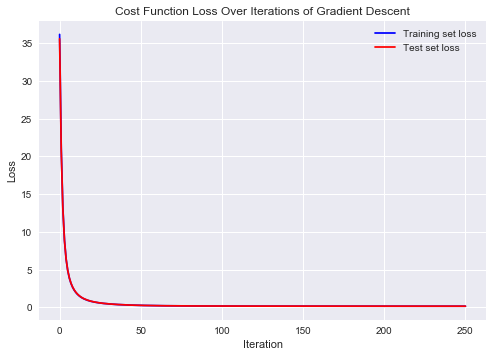

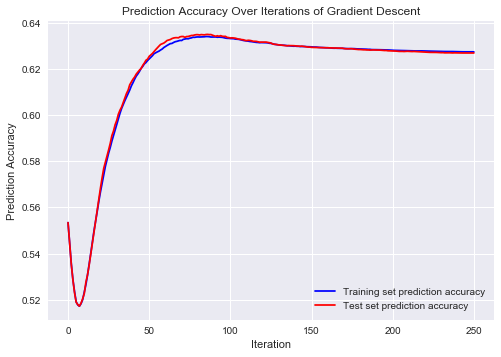

In [5]:
initial_w = np.ones(X_train.shape[1])
losses, ws = least_squares_GD(y_train, X_train, initial_w, max_iters = 250) # fit model and retrieve W's across iterations
test_losses = list(map(lambda x: compute_loss(y_test, X_test, x, method = 'MSE'), ws)) # retrieve losses using test set with ws

plt.style.use('seaborn')
plt.plot(losses, label='Training set loss', c='blue')
plt.plot(test_losses, label='Test set loss', c='red')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Cost Function Loss Over Iterations of Gradient Descent')
plt.legend()
plt.show()

# Make plot with label prediction accuracy

pred_ytrain = list(map(lambda x: predict_labels(x, X_train), ws)) # Training prediction
pred_accuracytrain = list(map(lambda x: pred_accuracy(x, y_train), pred_ytrain))
pred_ytest = list(map(lambda x: predict_labels(x, X_test), ws)) # Test prediction
pred_accuracytest = list(map(lambda x: pred_accuracy(x, y_test), pred_ytest))


plt.plot(pred_accuracytrain, label='Training set prediction accuracy', c='blue')
plt.plot(pred_accuracytest, label='Test set prediction accuracy', c='red')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Prediction Accuracy')
plt.title('Prediction Accuracy Over Iterations of Gradient Descent')
plt.show()


Linear regression with stochastic gradient descent (SGD)
===

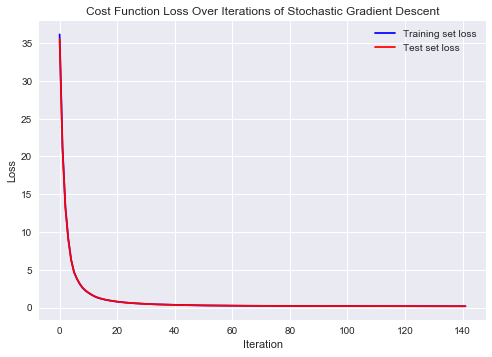

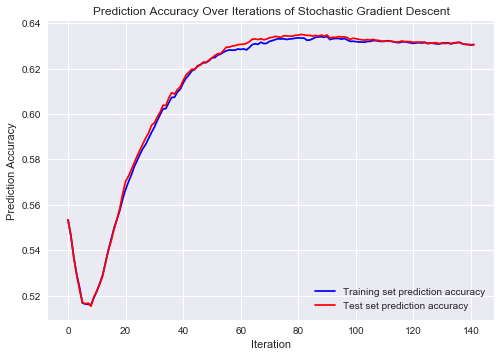

In [6]:
initial_w = np.ones(X_train.shape[1])
losses, ws = least_squares_SGD(y_train, X_train, initial_w, max_iters = 250) # fit model, retrieve parameters ws
test_losses = list(map(lambda x: compute_loss(y_test, X_test, x, method = 'MSE'), ws)) # retrieve losses using test set with ws

plt.style.use('seaborn')
plt.plot(losses, label='Training set loss', c='blue')
plt.plot(test_losses, label='Test set loss', c='red')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Cost Function Loss Over Iterations of Stochastic Gradient Descent')
plt.legend()
plt.show()

# Make plot with label prediction accuracy

pred_ytrain = list(map(lambda x: predict_labels(x, X_train), ws)) # Training prediction
pred_accuracytrain = list(map(lambda x: pred_accuracy(x, y_train), pred_ytrain))
pred_ytest = list(map(lambda x: predict_labels(x, X_test), ws)) # Test prediction
pred_accuracytest = list(map(lambda x: pred_accuracy(x, y_test), pred_ytest))


plt.plot(pred_accuracytrain, label='Training set prediction accuracy', c='blue')
plt.plot(pred_accuracytest, label='Test set prediction accuracy', c='red')
plt.legend()
plt.xlabel('Iteration')
plt.ylabel('Prediction Accuracy')
plt.title('Prediction Accuracy Over Iterations of Stochastic Gradient Descent')
plt.show()


Linear regression using least squares normal equations
===

In [7]:
w = least_squares(y_train, X_train)

pred_y = predict_labels(w, X_test)
pred_accuracy(pred_y,y_test)

0.6253713009491904

Linear regression using the normal equations with additional polynomial degrees
===

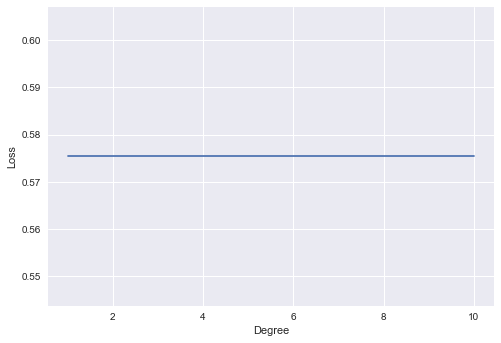

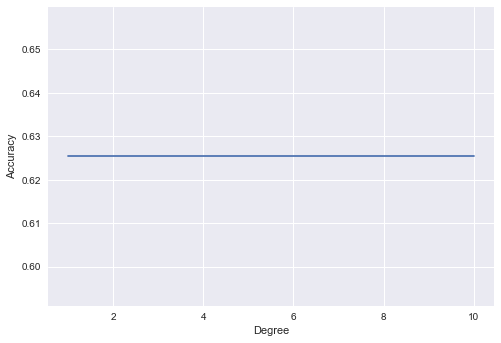

0.6253713009491904


In [8]:
degrees = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
rmse = []
pred = []

for ind, degree in enumerate(degrees):
    w = polynomial_regression(y_train, X_train, degree)
    rmse.append(np.sqrt(2 * compute_loss(y_test, X_test, w)))
    pred_y = predict_labels(w, X_test)
    pred.append(pred_accuracy(pred_y,y_test))

plt.style.use('seaborn')
plt.plot(degrees,rmse)
plt.xlabel('Degree')
plt.ylabel('Loss')
plt.show()

plt.style.use('seaborn')
plt.plot(degrees,pred)
plt.xlabel('Degree')
plt.ylabel('Accuracy')
plt.show()

print(np.max(pred))

# Linear regression using normal equation on polynomial models

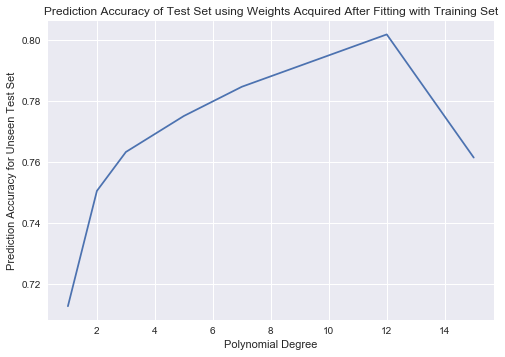

In [9]:
# Make chart as a function of polynomial. On the y axis is the prediction accuracy
def pred_accuracy(predict, y):
    compare = (predict == y)
    percent = compare.mean()
    return percent

prediction_accuracy = []
degrees = [1,2,3,5,7,12,15]

for degree in degrees:
    X_train_poly = build_poly(X_train, degree)
    X_test_poly = build_poly(X_test, degree)
    w = least_squares(y_train, X_train_poly)
    
    pred_ytest = predict_labels(w, X_test_poly)
    pred_accu = pred_accuracy(pred_ytest, y_test)
    prediction_accuracy.append(pred_accu)
    
plt.plot(degrees, prediction_accuracy)
plt.title('Prediction Accuracy of Test Set using Weights Acquired After Fitting with Training Set')
plt.xlabel('Polynomial Degree')
plt.ylabel('Prediction Accuracy for Unseen Test Set')
plt.show()



Linear regression using ridge regression
===

In [ ]:
lambdas = np.logspace(-5, 0, 15)
rmse = []
pred = []

for ind, lambda_ in enumerate(lambdas):
    
    w = ridge_regression(y_train, X_train, lambda_)
    rmse.append(np.sqrt(2 * compute_loss(y_test, X_test, w)))
    pred_y = predict_labels(w, X_test)
    pred.append(pred_accuracy(pred_y,y_test))
    
plt.style.use('seaborn')
plt.semilogx(lambdas,rmse)
plt.xlabel('Lambda')
plt.ylabel('Loss')
plt.show()

plt.style.use('seaborn')
plt.semilogx(lambdas,pred)
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.show()

print(np.max(pred))